# Energy spectrum

I calculate the energy spectrum of bacterial turbulence in this notebook. Energy spectrum quantifies the energy distribution over different length scales, $\lambda=2\pi/k$, where $k$ is the wavenumber. To obtain the energy spectrum, we first calculate the Fourier trransform of the 2D velocity field $v_x(x, y)$ and $v_y(x, y)$ to obtain $u_k(k_x, k_y)$ and $v_k(k_x, k_y)$. The point wise kinetic energy density in the k-space is then computed as $E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2$, where \* represents the complex conjugate. Finally, the energy spectrum E(k) is obtained by summing up $E(k_x, k_y)$ at a constant $k=(k_x^2+k_y^2)^{1/2}$. 

An alternative way to calculate $E(k)$ is through the Fourier transform of the two-point velocity correlation function $\langle v(r_0)\cdot v(r_0+r)\rangle_{r_0}$, which should yields quantitatively similar results.

This notebook will make clear the following things:

- the `numpy` built-in function `numpy.fft.fftfreq()`, what exactly it returns (Section 1)
- energy spectrum computation (Section 2)
    - 3 different methods: velFT, corrFT, E11
    - compare the results of the 3 methods
        - `numpy.fft.fft` returns complex numbers even when transforming even functions, use `numpy.fft.hfft`
        - compare `numpy.fft.hfft` and manual FT
        - compare high and low concentrations
- verification of the 3 methods (Section 3)

## 0 Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from corr_utils import *
import typesetting.main as tm
tm.prl('1-column-2-panel')
from corrLib import *
from scipy.integrate import *

## 1 Wavenumber magnitude field

In order to apply the isotropic assumption, we need to generate a wavenumber $k$ field (magnitude), in correspondance with the fft field. For example, for a 5-by-5 fft field, the corresponding $k_x$ field is
$$\begin{matrix}
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
0 & 1 & 2 & -2 & -1 \\
\end{matrix}
$$
the corresponding $k_y$ field is:
$$\begin{matrix}
0 & 0 & 0 & 0 & 0 \\
1 & 1 & 1 & 1 & 1 \\
2 & 2 & 2 & 2 & 2 \\
-2 & -2 & -2 & -2 & -2 \\
-1 & -1 & -1 & -1 & -1 \\
\end{matrix}
$$

`numpy` has a built-in function `numpy.fft.fftfreq()` for calculating wavenumber field for 1-D data. We first test this function, and then implement a 2-D version based on it.

**Test `numpy.fft.fftfreq()`**

Apply this function on a function with known wavenumber, and calibrate the parameter until the function returns the expected wavenumber. For example, function $f(x)=\cos x$, the wave number corresponding to the peak is $1/2\pi$, around 0.159.

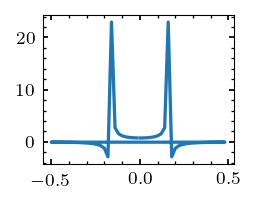

In [9]:
x = np.linspace(0, 50)
y = np.cos(x)
fft = np.fft.fft(y)
freq = np.fft.fftfreq(len(x), d=1)
plt.plot(freq, fft)

When the parameter $d$ of function `numpy.fft.fftfreq(len, d)` is set to 1, the distance between adjacent data point in $x$, the peak wavenumber is the same as expected. Thus, if we put the actual distance in certain unit between two adjacent points as $d$, say 8.33 um in this experiment, the resultant $k$ field will have unit um$^{-1}$.

**2D fftfreq function**

In [11]:
help(compute_wavenumber_field)

Help on function compute_wavenumber_field in module corrLib:

compute_wavenumber_field(shape, d)
    Compute the wave number field Kx and Ky, and magnitude field k. 
    Note that this function works for even higher dimensional shape.
    
    Args:
    shape -- shape of the velocity field and velocity fft field, tuple
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The preferred unit of d is um.
    
    Returns:
    k -- wavenumber magnitude field
    K -- wavenumber fields in given dimensions
    
    Test:
    shape = (5, 5)
    k, K = compute_wavenumber_field(shape, 0.2)



## 2 Compute energy spectrum

### 2.1 Three methods

3 different methods are present to me. I call them `velFT`, `corrFT` and `E11` based on the computation details, which will be described below.

#### 2.1.1 velFT
$$
E(k_x, k_y) = \langle u_k(k_x, k_y)u^*_k(k_x, k_y)+v_k(k_x, k_y)v_k^*(k_x, k_y)\rangle/2
$$

In [12]:
help(energy_spectrum)

Help on function energy_spectrum in module corrLib:

energy_spectrum(pivData, d=8.25)
    Compute energy spectrum (E vs k) from pivData.
    
    Args:
    pivData -- piv data
    d -- sample spacing. This is the distance between adjacent samples, for example, velocities in PIV. 
        The resulting frequency space has the unit which is inverse of the unit of d. The default unit of d is um.
    
    Returns:
    es -- energy spectrum, DataFrame (k, E)
    
    Edit:
    10192020 -- add argument d as sample spacing



Text(0.02, 585.2825164504771, '-2.5')

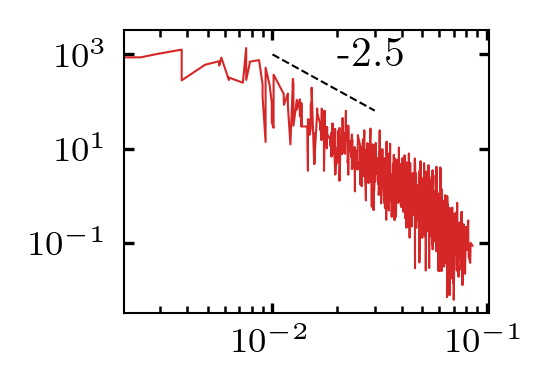

In [25]:
pivData = pd.read_csv(r'D:\density_fluctuations\08032020\piv_imseq\08\3000-3001.csv')
es = energy_spectrum(pivData, d=25*0.33)
plt.figure(dpi=300)
plt.plot(es.k, es.E*0.33*0.33, lw=0.5, color=bestcolor(3))
plt.loglog()

x = np.array([0.01,0.03])
y = x ** -2.5* 1e-2
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-2.5')

#### 2.1.2 corrFT

$$
E(k)=\frac{1}{(2\pi)^2}\int  e^{-ikR} \langle v(t, r)\cdot v(t, r+R)\rangle d^2 R
$$

(*Fluid mechanics, turbulent flow and turbulence modeling*, Lars Davidson, pp 443)

In [2]:
X, Y, U, V = read_piv(r'D:\density_fluctuations\08032020\piv_imseq\08\3000-3001.csv')
XS, YS, CA, CV = vspatial(X, Y, U, V)

- visualize piv and two-point velocity correlation

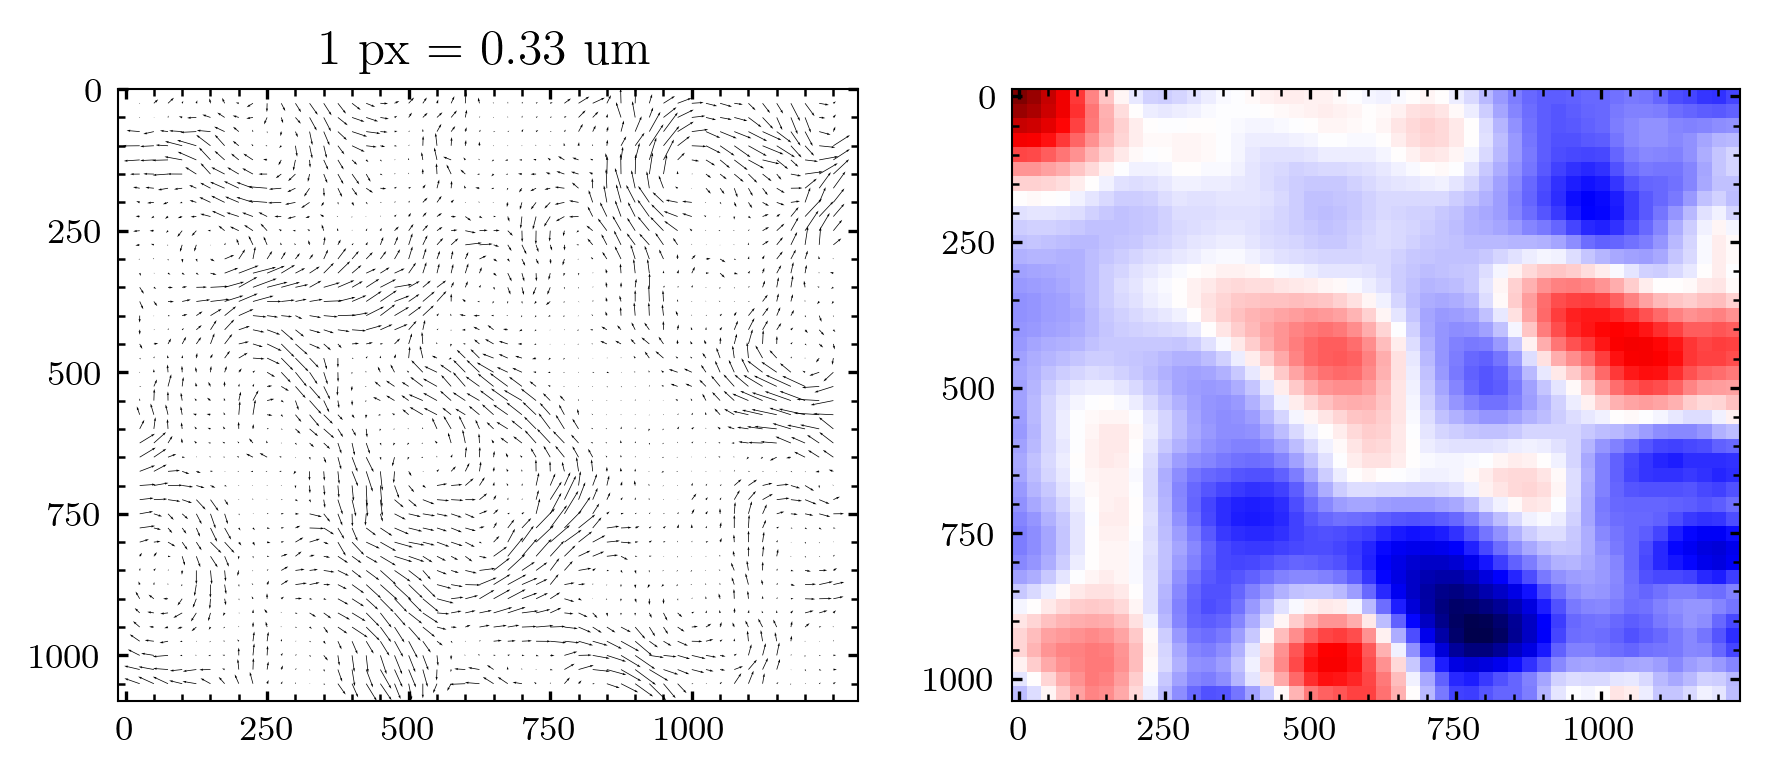

In [3]:
visualize_two_point_correlation(X, Y, U, V, CV)

- Calculate energy spectrum and visualize the decay of energy density with wavenumber $k$

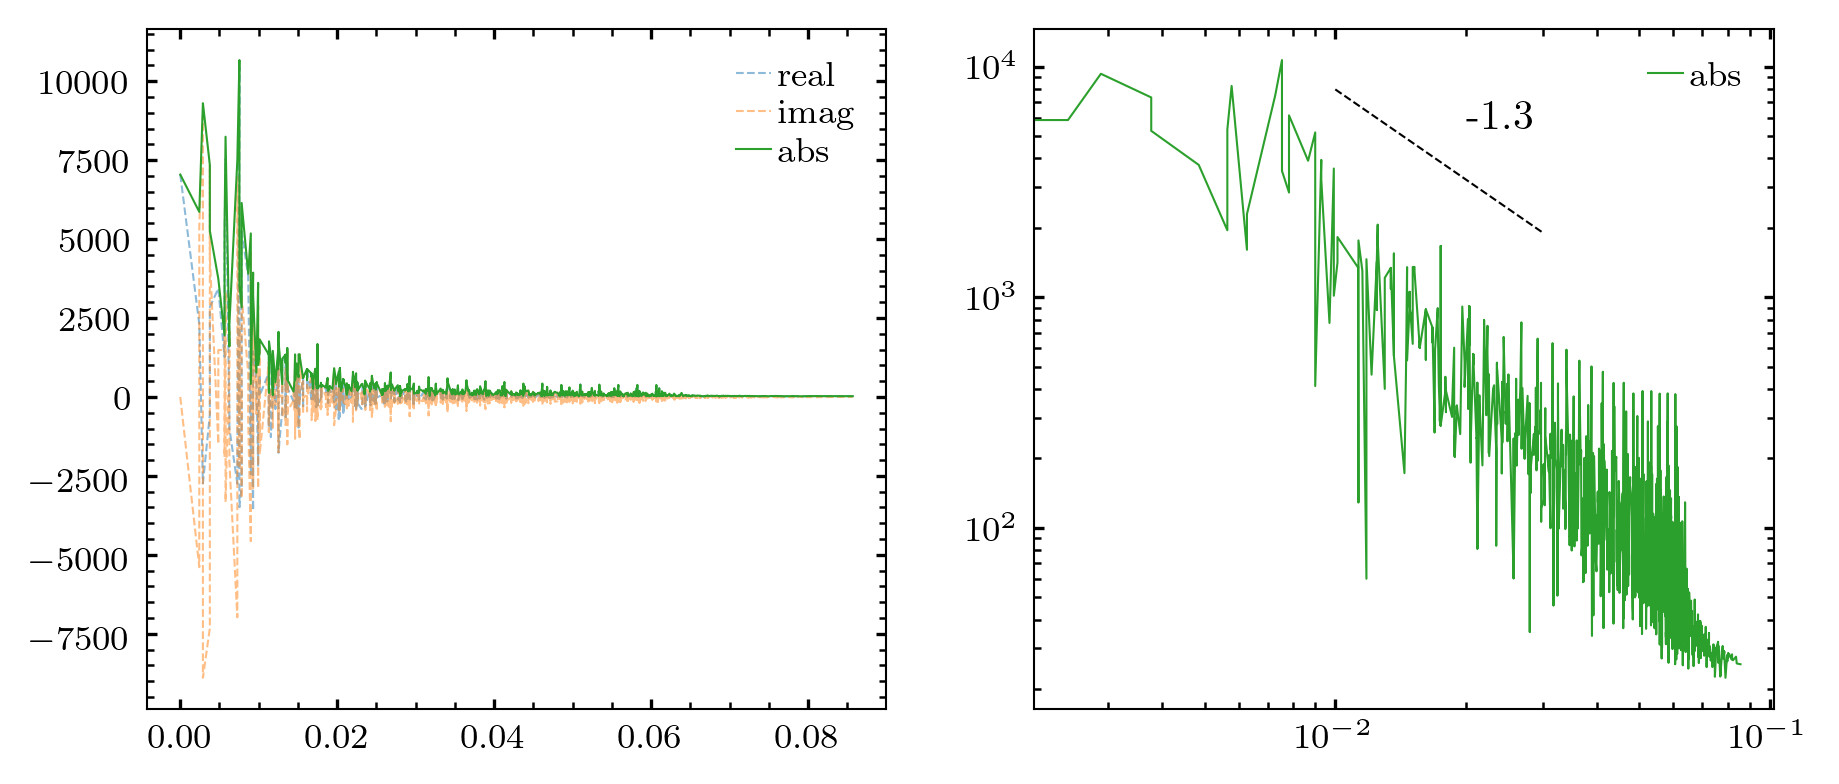

In [4]:
calculate_and_visualize_energy_spectrum(CV)

#### 2.1.3 E11 ("The textbook")

Energy spectrum function $E(k)$ is defined as
$$
E(k) = \oint \frac{1}{2} \Phi_{ii}(k)d S(k)
$$

where $\Phi_{ii}(k)$ is the diagonal term of velocity spectrum tensor, defined as

$$
\Phi_{ij}(k) = \iiint\limits_{-\infty}^{\infty} R_{ij}(r)e^{-ik\cdot r} dr
$$

here $r$ is position vector (x, y, z) and $R_{ij}$ is spatial velocity correlation of $u_i$, $u_j$ and $u_k$.

It is not feasible to measure the full 3 dimensional flow simultaneous, so take a step back and measure $R_{11}(x, y)$, and thus $\Phi_{11}(k_x, k_y)$.

One dimensional spectra $E_{ij}(k_1)$ are defined to be twice the one dimensional Fourier transform of $R_{ij}(e_1r_1)$:
$$
E_{ij}(k_1) \equiv \frac{1}{\pi}\int^\infty_{-\infty} R_{ij}(e_1r_1)e^{-ik_1r_1}d r_1
$$

Since the flow in the textbook is measured by hot wire, which is naturally 1D, whereas PIV is naturally 2D, I adapt the equation above to a 2D velocity correlation function version:
$$
E_{11}(k_x, k_y) \equiv \int^\infty_{-\infty} R_{11}(x, y)cos(k\cdot r)dr
$$

<font color='red'>Let's not worry about the prefactor at the moment. I will come back to it later.</font>

Text(0.5, 1.0, '$R_{22}$')

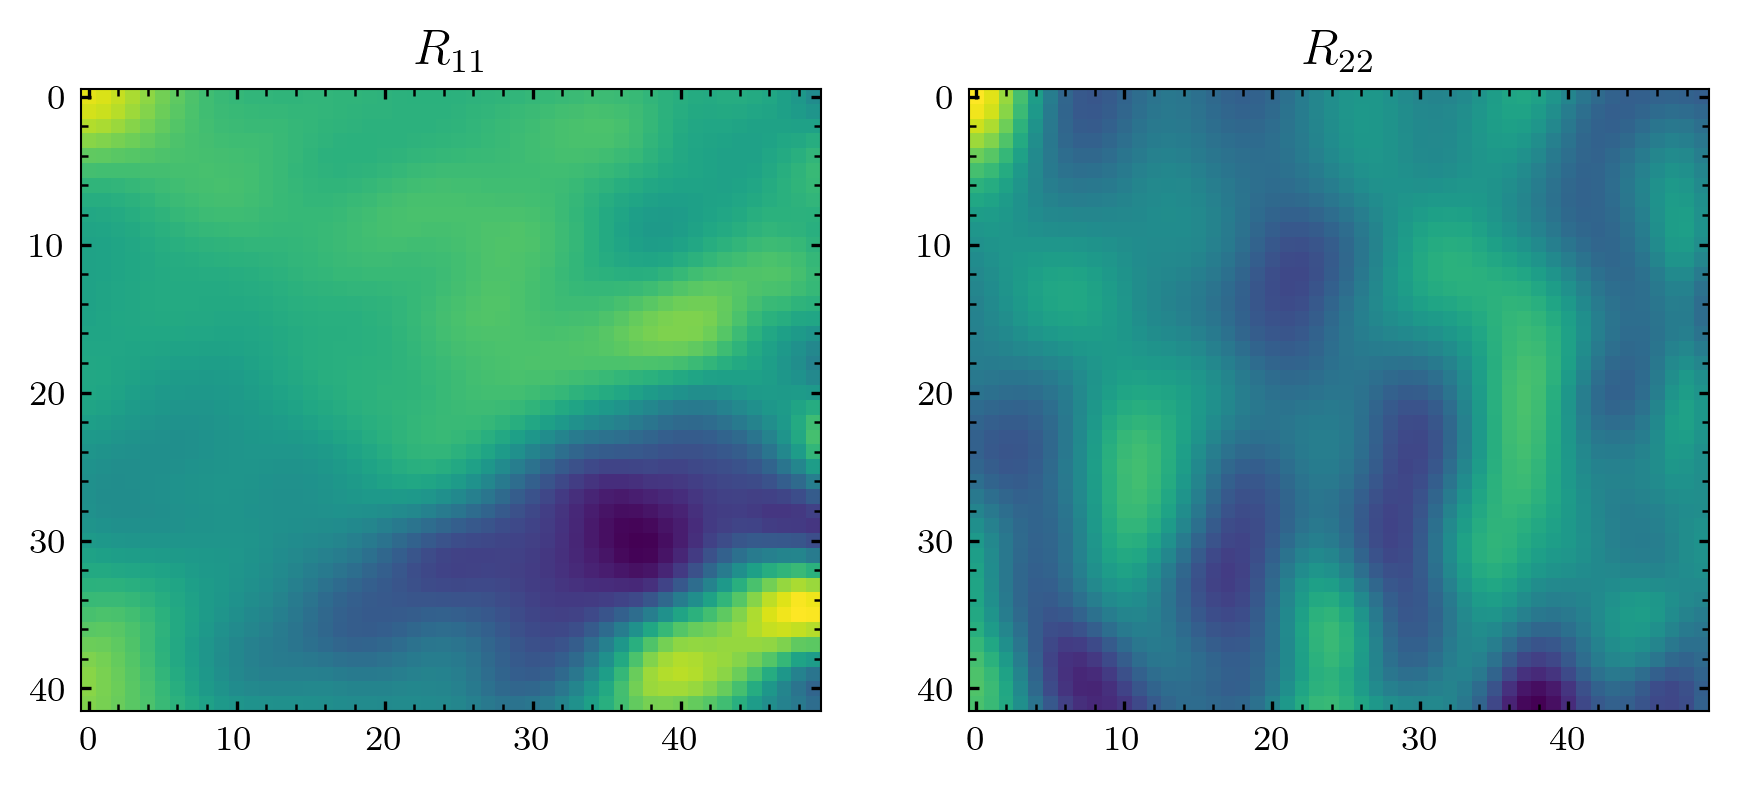

In [4]:
pivDir = r'E:\moreData\08032020\piv_imseq\01\3000-3001.csv'
X, Y, U, V = read_piv(pivDir)
U *= 0.33
V *= 0.33
R11 = spatial_correlation(U, U)
R22 = spatial_correlation(V, V)

fig, ax = plt.subplots(nrows=1, ncols=2, dpi=300, figsize=(7, 3))
ax[0].imshow(R11)
ax[0].set_title('$R_{11}$')
ax[1].imshow(R22)
ax[1].set_title('$R_{22}$')

**Compare hfft and manual FT**

The `numpy` built-in Fourier transform `fft.fft2` gives imaginary number even for perfect even $\cos x$ function. Here I manually compute the transform and compare with the built-in function. 

$$
A_k = \sum\limits^{n-1}_{m=0} a_m \exp \left[-2\pi i \frac{mk}{n}\right]
$$

where $m=0,...,n-1$

In our case, since the input data is always even, we transform with only $\cos$'s, i.e.
$$
A_k = \sum\limits^{n-1}_{m=0} a_m \cos \left[-2\pi  \frac{mk}{n}\right]
$$

where $m=0,...,n-1$

In [471]:
E11_xy = {}
r, c = R11.shape
E11_xy['hfft'] = np.fft.hfft(np.fft.hfft(R11), axis=0)
E11_xy['mft'] = efft(efft(R11), axis=0)

[]

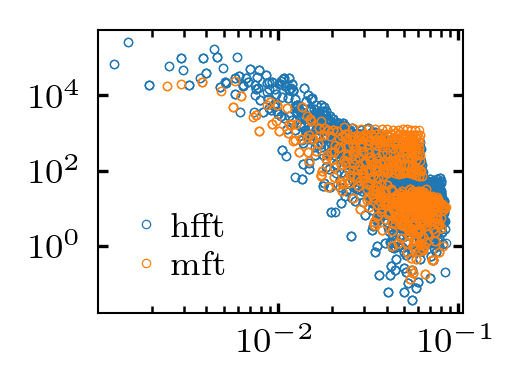

In [473]:
fig, ax = plt.subplots(dpi=300)
for num, kw in enumerate(E11_xy):
    k, K = compute_wavenumber_field(E11_xy[kw].shape, d=25*0.33)
    ax.plot(k.flatten(), abs(E11_xy[kw]).flatten(), label=kw, 
           ls='', marker='o', mew=0.3, mec=bestcolor(num), mfc=(0,0,0,0), markersize=2)
ax.legend()
ax.loglog()

<font color='blue'>**Comment:** the overall trends for the `hfft` and manual FT are similar. Since the built-in function is more robust to different parameters such as FFT in different axes, I use `hfft` from here on.

### 2.2 Compare the three methods

Clearly, the three methods presented above give different energy spectrum result. Below I plot them on the same axis and compare the difference.

#### 2.2.1 Compare on one frame PIV

Note that among the 3 methods `velFT`, `corrFT` and `E11`, only `velFT` is all positive. When plotting on loglog, the other two (both based on FT of velocity correlation) should plot the absolute values.

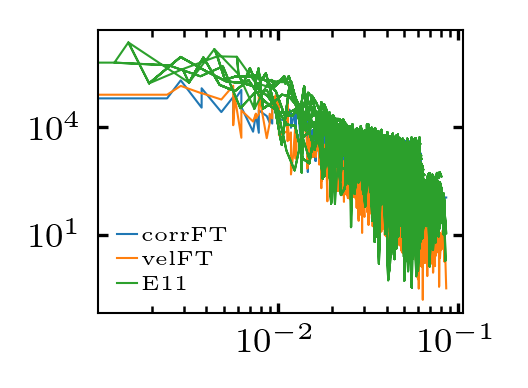

In [531]:
pivDir = r'D:\density_fluctuations\08032020\piv_imseq\01\3000-3001.csv'
plt.figure(dpi=300)

X, Y, U, V = read_piv(pivDir)
XS, YS, CA, CV = vspatial(X, Y, U, V)
k, E = energy_spectrum_2(CV)
plt.plot(k, abs(E), lw=0.5, color=bestcolor(0), label='corrFT')

pivData = pd.read_csv(pivDir)
es = energy_spectrum(pivData, d=25*0.33)
plt.plot(es.k, es.E, lw=0.5, color=bestcolor(1), label='velFT')
plt.loglog()

R11 = spatial_correlation(U, U)
E11 = np.fft.hfft(np.fft.hfft(R11), axis=0)
k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
# E11 = np.fft.hfft(np.fft.hfft(R11, n=c), axis=0, n=r)
# E11 = efft(efft(R11), axis=0)
plt.plot(k.flatten(), abs(E11.flatten()), lw=0.5, color=bestcolor(2), label='E11')

# x = np.array([0.01,0.03])
# y = x ** -1.3 * 2e2
# plt.plot(x, y, lw=0.5, ls='--', color='black')
# plt.text(x.mean(), 1.1*y.mean(), '-1.3', {'fontsize':5})
    
# x = np.array([0.01,0.03])
# y = x ** -5* 1e-9
# plt.plot(x, y, lw=0.5, ls='--', color='black')
# plt.text(x[0], y[1], '-5', {'fontsize':5})

plt.legend(fontsize=5)

#### 2.2.2 Sparcify the plot and fit slope

The curves above are too dense, here I sparcify them to make the trend clearer.

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0, 0.5, '$E$ ($\\mu$m$^3$/s$^2$)')

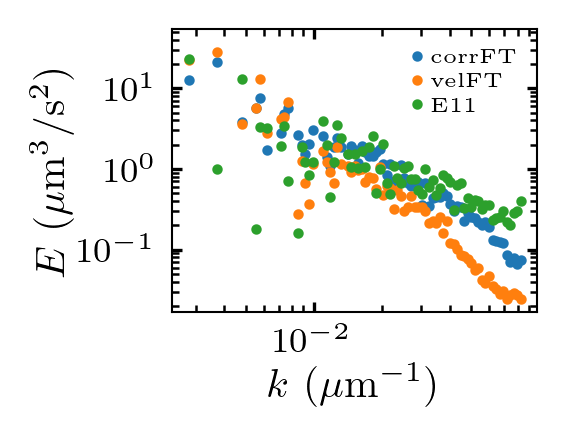

In [543]:
pivDir = r'D:\density_fluctuations\08032020\piv_imseq\10\3000-3001.csv'
plt.figure(dpi=300)

X, Y, U, V = read_piv(pivDir)
XS, YS, CA, CV = vspatial(X, Y, U, V)
k, E = energy_spectrum_2(CV)
x1, y1 = log_bin(k, abs(E)*0.33*0.33)
plt.plot(x1, y1, ls='', color=bestcolor(0), label='corrFT', marker='o', markersize=1.5)

pivData = pd.read_csv(pivDir)
es = energy_spectrum(pivData, d=25*0.33)
x2, y2 = log_bin(es.k, es.E*0.33*0.33, n=100)
plt.plot(x2, y2, ls='', color=bestcolor(1), label='velFT', marker='o', markersize=1.5)

R11 = spatial_correlation(U, U) * 0.33 * 0.33
# E11 = np.fft.hfft(np.fft.hfft(R11), axis=0)
E11 = efft(efft(R11), axis=0)
k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
x3, y3 = log_bin(k.flatten(), abs(E11.flatten()))
plt.plot(x3, y3, ls='', color=bestcolor(2), label='E11', marker='o', markersize=1.5)

plt.loglog()
plt.legend(fontsize=5)

# x = np.array([0.02,0.05])
# y = x ** -1.5 * 8e0
# plt.plot(x, y, lw=0.5, ls='--', color='black')
# plt.text(x.mean(), 1.1*y.mean(), '-1.5', {'fontsize':5})
    
# x = np.array([0.02,0.05])
# y = x ** -3* 1e-4
# plt.plot(x, y, lw=0.5, ls='--', color='black')
# plt.text(x[0], y[1], '-3', {'fontsize':5})

plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')

<font color='blue'>**Comment:** the plot above compares the energy spectra computed using 3 different methods. The results of `corrFT` and `E11` are so close and the relevant scaling exponent is about -1.5. The `velFT` shows a slope around -3, distinct from the other two methods.

#### 2.2.3 Average over multiple velocity fields

Seems not necessary for now.

### 2.3 Compare energy spectra at different concentrations

To validify the methods we use, testing at different phases of bacterial motion (disorder and order) is of key importance. Here, I test 3 methods at 3 different concentrations: 20, 40 and 80 n$_0$. These concentrations corresponds to disordered phase, transition and ordered phase.

#### 2.3.1 corrFT

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.02, 0.08944271909999157, '-1.5')

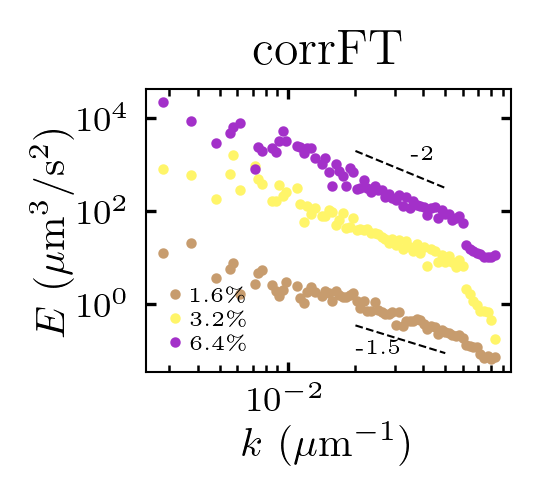

In [499]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = ['1.6\%', '3.2\%', '6.4\%']
for num, label in zip(numList, labelList):
    pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{:02d}\3000-3001.csv'.format(num)
    X, Y, U, V = read_piv(pivDir)
    XS, YS, CA, CV = vspatial(X, Y, U, V)
    k, E = energy_spectrum_2(CV)
    x1, y1 = log_bin(k, abs(E)*0.33*0.33)
    plt.plot(x1, y1, ls='', color=wowcolor(num), label=label, marker='o', markersize=1.5)
plt.loglog()
plt.legend(fontsize=5, loc='lower left')
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.title('corrFT')

x = np.array([0.02,0.05])
y = x ** -2 * 8e-1
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-2', {'fontsize':5})
    
x = np.array([0.02,0.05])
y = x ** -1.5* 1e-3
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x[0], y[1], '-1.5', {'fontsize':5})

#### 2.3.2 velFT

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.02, 0.039999999999999994, '-2')

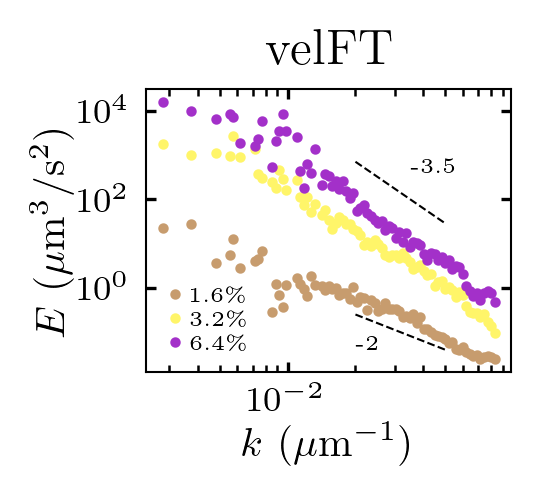

In [511]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = ['1.6\%', '3.2\%', '6.4\%']
for num, label in zip(numList, labelList):
    pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{:02d}\3000-3001.csv'.format(num)
    pivData = pd.read_csv(pivDir)
    es = energy_spectrum(pivData, d=25*0.33)
    x2, y2 = log_bin(es.k, es.E*0.33*0.33, n=100)
    plt.plot(x2, y2, ls='', color=wowcolor(num), label=label, marker='o', markersize=1.5)
plt.loglog()
plt.legend(fontsize=5, loc='lower left')
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.title('velFT')

x = np.array([0.02,0.05])
y = x ** -3.5 * 8e-4
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-3.5', {'fontsize':5})
    
x = np.array([0.02,0.05])
y = x ** -2* 1e-4
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x[0], y[1], '-2', {'fontsize':5})

#### 2.3.3 E11

**hfft**

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.02, 0.2, '-1')

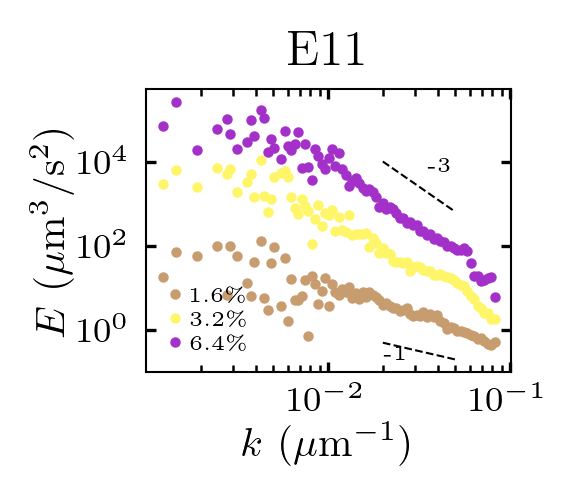

In [523]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = ['1.6\%', '3.2\%', '6.4\%']
for num, label in zip(numList, labelList):
    pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{:02d}\3000-3001.csv'.format(num)
    X, Y, U, V = read_piv(pivDir)
    R11 = spatial_correlation(U, U) * 0.33 * 0.33
    E11 = np.fft.hfft(np.fft.hfft(R11), axis=0)
#     E11 = efft(efft(R11), axis=0)
    k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
    x3, y3 = log_bin(k.flatten(), abs(E11.flatten()))
    plt.plot(x3, y3, ls='', color=wowcolor(num), label=label, marker='o', markersize=1.5)
plt.loglog()
plt.legend(fontsize=5, loc='lower left')
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.title('E11')

x = np.array([0.02,0.05])
y = x ** -3 * 8e-2
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-3', {'fontsize':5})
    
x = np.array([0.02,0.05])
y = x ** -1* 1e-2
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x[0], y[1], '-1', {'fontsize':5})

**mft**

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.02, 0.1, '-1')

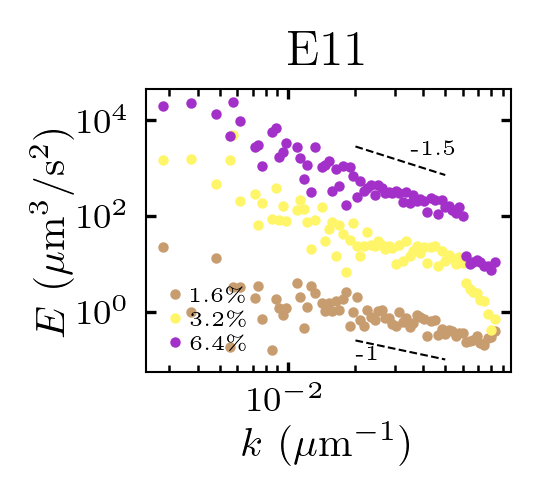

In [539]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = ['1.6\%', '3.2\%', '6.4\%']
for num, label in zip(numList, labelList):
    pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{:02d}\3000-3001.csv'.format(num)
    X, Y, U, V = read_piv(pivDir)
    R11 = spatial_correlation(U, U) * 0.33 * 0.33
#     E11 = np.fft.hfft(np.fft.hfft(R11), axis=0)
    E11 = efft(efft(R11), axis=0)
    k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
    x3, y3 = log_bin(k.flatten(), abs(E11.flatten()))
    plt.plot(x3, y3, ls='', color=wowcolor(num), label=label, marker='o', markersize=1.5)
plt.loglog()
plt.legend(fontsize=5, loc='lower left')
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.title('E11')

x = np.array([0.02,0.05])
y = x ** -1.5 * 8e0
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-1.5', {'fontsize':5})
    
x = np.array([0.02,0.05])
y = x ** -1* 5e-3
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x[0], y[1], '-1', {'fontsize':5})

#### 2.3.4 E11-exact (dumbest)

S:\Anaconda\3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.02, 0.1, '-1')

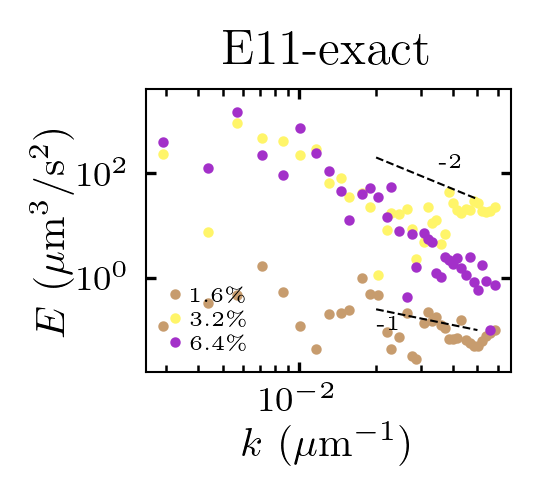

In [568]:
plt.figure(dpi=300)
numList = [10, 7, 1]
labelList = ['1.6\%', '3.2\%', '6.4\%']
for num, label in zip(numList, labelList):
    pivDir = r'D:\density_fluctuations\08032020\piv_imseq\{:02d}\3000-3001.csv'.format(num)
    X, Y, U, V = read_piv(pivDir)
    U = np.expand_dims(U[:, 30], axis=1)
    R11 = spatial_correlation(U, U) * 0.33 * 0.33
    E11 = np.fft.hfft(R11, axis=0)
#     E11 = efft(R11, axis=0)
    k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
    x3, y3 = log_bin(k.flatten(), abs(E11.flatten()))
    plt.plot(x3, y3, ls='', color=wowcolor(num), label=label, marker='o', markersize=1.5)
plt.loglog()
plt.legend(fontsize=5, loc='lower left')
plt.xlabel('$k$ ($\mu$m$^{-1}$)')
plt.ylabel('$E$ ($\mu$m$^3$/s$^2$)')
plt.title('E11-exact')

x = np.array([0.02,0.05])
y = x ** -2 * 8e-2
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x.mean(), 1.1*y.mean(), '-2', {'fontsize':5})
    
x = np.array([0.02,0.05])
y = x ** -1* 5e-3
plt.plot(x, y, lw=0.5, ls='--', color='black')
plt.text(x[0], y[1], '-1', {'fontsize':5})

In [553]:
R11.shape

(50, 1)

## 3 Verification

According to Wensink 2012, energy spectrum $E(k)$ is defined as
$$
\langle v^2\rangle = 2\int^\infty_0 E(k)dk
$$

Here, we use this criteria to verify the two methods.

In [518]:
pivDir = r'D:\density_fluctuations\08032020\piv_imseq\01\3000-3001.csv'

**Compute $\langle v^2\rangle$**

In [532]:
X, Y, U, V = read_piv(pivDir)
U *= 0.33
V *= 0.33
vms = (U**2 + V**2).mean()
vms / 2

175.15969097845004

**Method I: velFT**

In [520]:
pivData = pd.read_csv(pivDir)
es = energy_spectrum(pivData, d=25*0.33) 
velFT = trapz(es.E* 0.33 * 0.33, es.k)
velFT

99.91349516360107

**Method II: corrFT**

In [527]:
X, Y, U, V = read_piv(pivDir)
XS, YS, CA, CV = vspatial(X, Y, U, V)
k, E = energy_spectrum_2(CV)
corrFT = trapz(abs(E), k)
corrFT

753.1306277661133

**Method III: E11**

In [525]:
X, Y, U, V = read_piv(pivDir)
R11 = spatial_correlation(U, U) * 0.33 * 0.33
E11 = np.fft.hfft(np.fft.hfft(R11), axis=0)
# E11 = efft(efft(R11), axis=0)
k, K = compute_wavenumber_field(E11.shape, d=25*0.33)
trapz(abs(E11.flatten()), k.flatten())

36.89051537927105

<font color='blue'>**Comment:** None of the 3 methods agrees with the definition perfectly. 